### 1  Setup & Imports  
Load core libraries for the regression workflow:

* **pandas / numpy** – data wrangling  
* **scikit‑learn** – linear‑regression model, train‑test split, and MAE metric  
* **matplotlib** – plot predicted vs actual values

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


### 2  Data Wrangling & Outlier Removal  
This function loads the raw rental data and drops extreme outliers to focus our model on the central 99% of values:

1. **Read CSV** from the given URL using `pd.read_csv`.  
2. **Filter price** to keep only the middle 99% (remove both the lowest 0.5% and highest 0.5%).  
3. **Filter latitude / longitude** to drop the outer 0.1% at each end (remove geo-coordinates in the extreme 0.05th and 99.95th percentiles).  

By trimming these extreme values, we reduce the influence of unusually cheap/expensive listings and GPS errors.

In [ ]:
def wrangle(filepath):
    df = pd.read_csv(filepath)

    # Removed the most extreme 1% prices,
    # the most extreme .1% latitudes, &
    # the most extreme .1% longitudes
    df = df[(df['price'] >= np.percentile(df['price'], 0.5)) &
            (df['price'] <= np.percentile(df['price'], 99.5)) &
            (df['latitude'] >= np.percentile(df['latitude'], 0.05)) &
            (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
            (df['longitude'] >= np.percentile(df['longitude'], 0.05)) &
            (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

    return df

filepath = 'https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Linear-Models/master/data/apartments/renthop-nyc.csv'

In [4]:
df = wrangle(filepath)

df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,...,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,...,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,...,0,0,0,0,0,0,0,0,0,0


### 3  Exploratory Scatter: Bedrooms vs. Price  
Plotting **bedrooms** against **price** to visually inspect any relationship.  Each point is an apartment listing—this helps us see if listings with more bedrooms generally ask for higher rent, or if there’s no clear pattern.


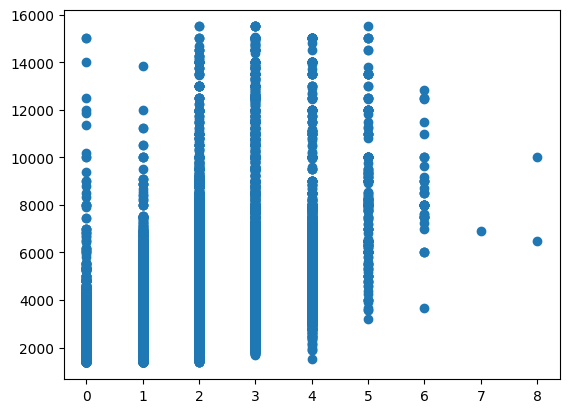

In [ ]:
X = df [['bedrooms']]
y = df ['price']
plt.scatter (X, y)

### 4  Define Features & Target  
Separating the data into **X** (feature matrix) and **y** (target vector) for modeling:

* **X =** the `bedrooms` column (number of bedrooms).  
* **y =** the `price` column (monthly rent).  

In [6]:
X = df [['bedrooms']]
y = df['price']

y.head()

0    3000
1    5465
2    2850
3    3275
4    3350
Name: price, dtype: int64

### 5  Baseline Model – Predict the Mean   
Before fitting any regression model, we establish a simple baseline:  
1. Compute **y_mean** = average rent across all listings.  
2. Create **y_pred** as a list of length `len(y)` where every predicted value equals y_mean.  
3. Calculate **Baseline MAE** between the true prices (`y`) and these constant predictions using `mean_absolute_error`.

This baseline tells us “if we always predict the average rent, we’ll be off by about Baseline MAE on average.” Any useful model should achieve a lower MAE than this.

In [7]:
y_mean = y.mean()
y_pred = [y.mean()]* len(y)
baseline_mae = mean_absolute_error (y, y_pred)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 1201.532252154329


### 6  Train the Linear Regression Model  
1. **Import** the `LinearRegression` class from `sklearn.linear_model`.  
2. **Instantiate** a new model object (`model = LinearRegression()`).  
3. **Fit** the model on the full dataset (`model.fit(X, y)`), so it learns the relationship between **bedrooms** (feature) and **price** (target).


In [8]:
# Import predictor class
from sklearn.linear_model import LinearRegression

# Instantiate predictor
model = LinearRegression()

# Fit predictor on the (training) data
model.fit(X,y)

LinearRegression()

### 7  Evaluate Model Performance on Training Data  
After fitting the model, we generate predictions (y_pred) on the same dataset and compute the **Mean Absolute Error (MAE)** to quantify how far off our model’s rent estimates are, on average, compared to the true prices.

* **y_pred:** predicted rent values from the model  
* **Training MAE:** `mean_absolute_error(y, y_pred)`—lower values mean better fit  

In [9]:
training_mae = mean_absolute_error (y, y_pred)

print('Training MAE:', training_mae)

Training MAE: 1201.532252154329


### 8  Model Coefficients & Interpretation  
Extracting the **intercept** and **slope (coefficient)** from the trained linear regression model:

* **Intercept (≈ X)**: The predicted rent when `bedrooms = 0`.  In practice, it’s a baseline rent level—often not directly meaningful if `0` bedrooms don’t exist, but it anchors the line.  
* **Coefficient (≈ Y)**: The estimated **rent increase per additional bedroom**.  For each extra bedroom, the model predicts rent will go up by about **Y** dollars.

By printing these values, we can communicate that, for example, a two-bedroom apartment is expected to rent at `Intercept + 2 × Coefficient`.


In [24]:
intercept = round(model.intercept_)

coef = model.coef_[0]

print (f"Intercept: {intercept} , Coef: {coef}")

pred_2_bed = model.predict([[2]])[0]
print (f"Predicted rent for a 2-bedroom apartment: ${round(pred_2_bed)} ")

Intercept: 2268 , Coef: 853.2664084832675
Predicted rent for a 2-bedroom apartment: $3975 


c:\Users\UserOne\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
